In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Generate dataset

In [2]:
y = np.random.randint(0,7,2100)
idx= []
for i in range(7):
    print(i,sum(y==i))
    idx.append(y==i)

0 312
1 302
2 306
3 286
4 306
5 296
6 292


In [3]:
x = np.zeros((2100,2))

In [4]:


x[idx[0],:] = np.random.uniform(low=[1,5],high=[2,6],size=(sum(idx[0]),2))

x[idx[1],:] = np.random.uniform(low=[1,3],high=[2,4],size=(sum(idx[1]),2))

x[idx[2],:] = np.random.uniform(low=[1,1],high=[2,2],size=(sum(idx[2]),2))

x[idx[3],:] = np.random.uniform(low=[1,-1],high=[2,0],size=(sum(idx[3]),2))

x[idx[4],:] = np.random.uniform(low=[1,-3],high=[2,-2],size=(sum(idx[4]),2))

x[idx[5],:] = np.random.uniform(low=[1,-5],high=[2,-4],size=(sum(idx[5]),2))


x[idx[6],:] = np.random.uniform(low=[5,5],high=[6,6],size=(sum(idx[6]),2))




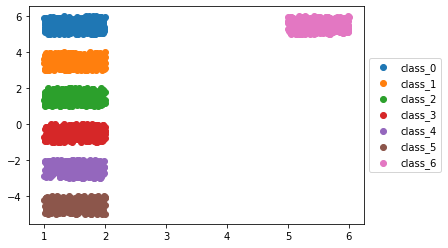

In [5]:
for i in range(7):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("type3_2_dist.png",bbox_inches="tight")
plt.savefig("type3_2_dist.pdf",bbox_inches="tight")


In [6]:
foreground_classes = {'class_0','class_1'}

background_classes = {'class_2'}

In [7]:
fg_class  = np.random.randint(0,6)
fg_idx = np.random.randint(0,2) #m=2

a = []
for i in range(2): #m=2
    if i == fg_idx:
        b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
        a.append(x[b])
        print("foreground "+str(fg_class)+" present at " + str(fg_idx))
    else:
        bg_class = np.random.randint(6,7)
        b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
        a.append(x[b])
        print("background "+str(bg_class)+" present at " + str(i))
a = np.concatenate(a,axis=0)
print(a.shape)

print(fg_class , fg_idx)

background 6 present at 0
foreground 1 present at 1
(2, 2)
1 1


In [8]:
a.shape

(2, 2)

In [9]:
np.reshape(a,(4,1))

array([[5.9560374 ],
       [5.52692736],
       [1.32577285],
       [3.93114975]])

In [10]:
desired_num = 3000
mosaic_list =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    fg_class  = np.random.randint(0,6)
    fg_idx = np.random.randint(0,2) #m=2
    a = []
    for i in range(2):  #m=2
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(6,7)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list.append(np.reshape(a,(4,1)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

In [11]:
mosaic_list = np.concatenate(mosaic_list,axis=1).T
# print(mosaic_list)

In [12]:
print(np.shape(mosaic_label))
print(np.shape(fore_idx))

(3000,)
(3000,)


In [13]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [14]:
class Wherenet(nn.Module):
    def __init__(self):
        super(Wherenet,self).__init__()
        self.linear1 = nn.Linear(2,1)

    def forward(self,z):
        x = torch.zeros([batch,2],dtype=torch.float64)  #m=2
        y = torch.zeros([batch,2], dtype=torch.float64)
        #x,y = x.to("cuda"),y.to("cuda")
        for i in range(2):  #m=9
          x[:,i] = self.helper(z[:,2*i:2*i+2])[:,0]
            #print(k[:,0].shape,x[:,i].shape)
        x = F.softmax(x,dim=1)   # alphas
        x1 = x[:,0]
        for i in range(2): #m=2
            x1 = x[:,i]          
            #print()
            y = y+torch.mul(x1[:,None],z[:,2*i:2*i+2])
        return y , x 

    
    def helper(self,x):
        #x = F.relu(self.linear1(x))
        #x = F.relu(self.linear2(x))
        x = self.linear1(x)
        return x

    

In [15]:
trainiter = iter(train_loader)
input1,labels1,index1 = trainiter.next()



In [16]:
where = Wherenet().double()
where = where
out_where,alphas = where(input1)
out_where.shape,alphas.shape

(torch.Size([250, 2]), torch.Size([250, 2]))

In [17]:
class Whatnet(nn.Module):
    def __init__(self):
        super(Whatnet,self).__init__()
        self.linear1 = nn.Linear(2,6)
        #self.linear2 = nn.Linear(4,3)
#         self.linear3 = nn.Linear(8,3)
    def forward(self,x):
        #x = F.relu(self.linear1(x))
        #x = F.relu(self.linear2(x))
        x = self.linear1(x)
        return x

In [18]:
what = Whatnet().double()
# what(out_where)

In [19]:
test_data_required = 1000
mosaic_list_test =[]
mosaic_label_test = []
fore_idx_test=[]
for j in range(test_data_required):
    fg_class  = np.random.randint(0,6)
    fg_idx = np.random.randint(0,2)  #m=2
    a = []
    for i in range(2): #m=2
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(6,7)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_test.append(np.reshape(a,(4,1)))
    mosaic_label_test.append(fg_class)
    fore_idx_test.append(fg_idx)

In [20]:
mosaic_list_test = np.concatenate(mosaic_list_test,axis=1).T
print(mosaic_list_test.shape)

(1000, 4)


In [21]:
test_data = MosaicDataset(mosaic_list_test,mosaic_label_test,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [22]:

focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]

criterion = nn.CrossEntropyLoss()
optimizer_where = optim.Adam(where.parameters(), lr=0.1)#,momentum=0.9)
optimizer_what = optim.Adam(what.parameters(), lr=0.1)#, momentum=0.9)

nos_epochs = 200

train_loss=[]
test_loss =[]
train_acc = []
test_acc = []
for epoch in range(nos_epochs):  # loop over the dataset multiple times

    focus_true_pred_true =0
    focus_false_pred_true =0
    focus_true_pred_false =0
    focus_false_pred_false =0

    argmax_more_than_half = 0
    argmax_less_than_half =0

    running_loss = 0.0
    cnt=0

    iteration = desired_num // batch

    #training data set

    for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        #inputs,labels,fore_idx = inputs.to(device),labels.to(device),fore_idx.to(device)
        # zero the parameter gradients

        optimizer_what.zero_grad()
        optimizer_where.zero_grad()
        
        
        avg_inp,alphas = where(inputs)
        
        outputs = what(avg_inp)
        
        _, predicted = torch.max(outputs.data, 1)
        
        loss = criterion(outputs, labels) 
        loss.backward() 
        
        optimizer_what.step()
        optimizer_where.step() 
        

        running_loss += loss.item()
        if cnt % 6 == 5:    # print every 6 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / 6))
            running_loss = 0.0
        cnt=cnt+1
    
        if epoch % 5 == 4:
            for j in range (batch):
                focus = torch.argmax(alphas[j])

                if(alphas[j][focus] >= 0.5):
                    argmax_more_than_half +=1
                else:
                    argmax_less_than_half +=1

                if(focus == fore_idx[j] and predicted[j] == labels[j]):
                    focus_true_pred_true += 1

                elif(focus != fore_idx[j] and predicted[j] == labels[j]):
                    focus_false_pred_true +=1

                elif(focus == fore_idx[j] and predicted[j] != labels[j]):
                    focus_true_pred_false +=1

                elif(focus != fore_idx[j] and predicted[j] != labels[j]):
                    focus_false_pred_false +=1

    if epoch % 5 == 4:
        col1.append(epoch)
        col2.append(argmax_more_than_half)
        col3.append(argmax_less_than_half)
        col4.append(focus_true_pred_true)
        col5.append(focus_false_pred_true)
        col6.append(focus_true_pred_false)
        col7.append(focus_false_pred_false)

    #************************************************************************
        #testing data set  
        with torch.no_grad():
            focus_true_pred_true =0
            focus_false_pred_true =0
            focus_true_pred_false =0
            focus_false_pred_false =0

            argmax_more_than_half = 0
            argmax_less_than_half =0
            for data in test_loader:
                inputs, labels , fore_idx = data
                #inputs,labels,fore_idx = inputs.to(device),labels.to(device),fore_idx.to(device) 
#                 print(inputs.shtorch.save(where.state_dict(),"model_epoch"+str(epoch)+".pt")ape,labels.shape)
                avg_inp,alphas = where(inputs)
                outputs = what(avg_inp)
                _, predicted = torch.max(outputs.data, 1)

                for j in range (batch):
                    focus = torch.argmax(alphas[j])

                    if(alphas[j][focus] >= 0.5):
                        argmax_more_than_half +=1
                    else:
                        argmax_less_than_half +=1

                    if(focus == fore_idx[j] and predicted[j] == labels[j]):
                        focus_true_pred_true += 1

                    elif(focus != fore_idx[j] and predicted[j] == labels[j]):
                        focus_false_pred_true +=1

                    elif(focus == fore_idx[j] and predicted[j] != labels[j]):
                        focus_true_pred_false +=1

                    elif(focus != fore_idx[j] and predicted[j] != labels[j]):
                        focus_false_pred_false +=1

        col8.append(argmax_more_than_half)
        col9.append(argmax_less_than_half)
        col10.append(focus_true_pred_true)
        col11.append(focus_false_pred_true)
        col12.append(focus_true_pred_false)
        col13.append(focus_false_pred_false)
        
        #torch.save(where.state_dict(),"where_model_epoch"+str(epoch)+".pt")
        #torch.save(what.state_dict(),"what_model_epoch"+str(epoch)+".pt")
    
print('Finished Training')
#torch.save(where.state_dict(),"where_model_epoch"+str(nos_epochs)+".pt")
#torch.save(what.state_dict(),"what_model_epoch"+str(epoch)+".pt")


[1,     6] loss: 2.723
[1,    12] loss: 1.613
[2,     6] loss: 1.383
[2,    12] loss: 1.175
[3,     6] loss: 1.026
[3,    12] loss: 0.841
[4,     6] loss: 0.742
[4,    12] loss: 0.689
[5,     6] loss: 0.646
[5,    12] loss: 0.605
[6,     6] loss: 0.574
[6,    12] loss: 0.546
[7,     6] loss: 0.523
[7,    12] loss: 0.498
[8,     6] loss: 0.477
[8,    12] loss: 0.464
[9,     6] loss: 0.444
[9,    12] loss: 0.428
[10,     6] loss: 0.417
[10,    12] loss: 0.395
[11,     6] loss: 0.385
[11,    12] loss: 0.373
[12,     6] loss: 0.362
[12,    12] loss: 0.351
[13,     6] loss: 0.341
[13,    12] loss: 0.327
[14,     6] loss: 0.322
[14,    12] loss: 0.307
[15,     6] loss: 0.303
[15,    12] loss: 0.289
[16,     6] loss: 0.287
[16,    12] loss: 0.275
[17,     6] loss: 0.270
[17,    12] loss: 0.261
[18,     6] loss: 0.259
[18,    12] loss: 0.244
[19,     6] loss: 0.245
[19,    12] loss: 0.233
[20,     6] loss: 0.231
[20,    12] loss: 0.224
[21,     6] loss: 0.224
[21,    12] loss: 0.210
[22,     6

In [23]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [24]:
df_train

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,4,3000,0,2819,0,181,0
1,9,3000,0,2979,0,21,0
2,14,3000,0,2997,0,3,0
3,19,3000,0,3000,0,0,0
4,24,3000,0,3000,0,0,0
5,29,3000,0,3000,0,0,0
6,34,3000,0,3000,0,0,0
7,39,3000,0,3000,0,0,0
8,44,3000,0,3000,0,0,0
9,49,3000,0,3000,0,0,0


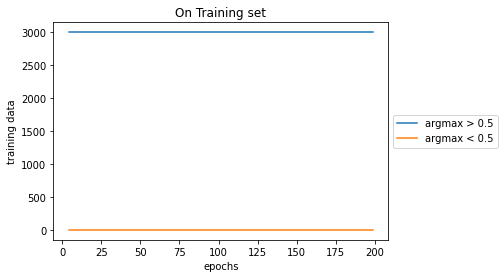

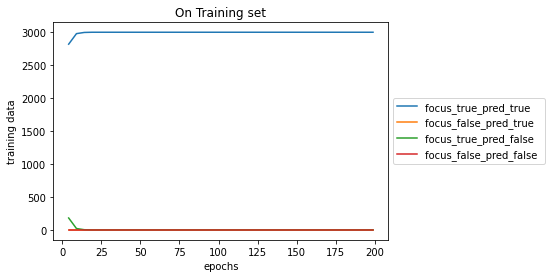

In [25]:
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.show()

plt.plot(col1,col4, label ="focus_true_pred_true ")
plt.plot(col1,col5, label ="focus_false_pred_true ")
plt.plot(col1,col6, label ="focus_true_pred_false ")
plt.plot(col1,col7, label ="focus_false_pred_false ")
plt.title("On Training set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.savefig("linear_type3_21.png",bbox_inches="tight")
plt.savefig("linear_type3_21.pdf",bbox_inches="tight")
plt.show()

In [26]:
df_test

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,4,1000,0,918,0,82,0
1,9,1000,0,990,0,10,0
2,14,1000,0,997,0,3,0
3,19,1000,0,1000,0,0,0
4,24,1000,0,1000,0,0,0
5,29,1000,0,1000,0,0,0
6,34,1000,0,1000,0,0,0
7,39,1000,0,1000,0,0,0
8,44,1000,0,1000,0,0,0
9,49,1000,0,1000,0,0,0


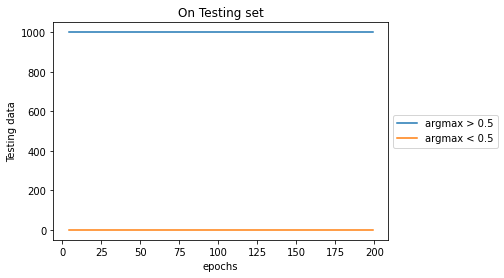

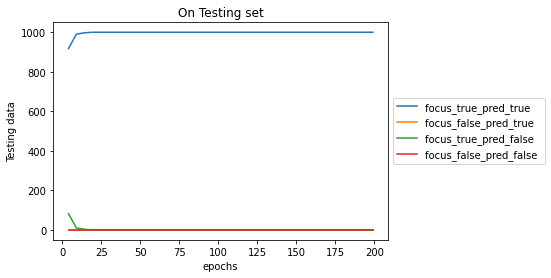

In [27]:
plt.plot(col1,col8, label='argmax > 0.5')
plt.plot(col1,col9, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.show()

plt.plot(col1,col10, label ="focus_true_pred_true ")
plt.plot(col1,col11, label ="focus_false_pred_true ")
plt.plot(col1,col12, label ="focus_true_pred_false ")
plt.plot(col1,col13, label ="focus_false_pred_false ")
plt.title("On Testing set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.show()

In [28]:
# where.state_dict()["linear1.weight"][:]  = torch.Tensor(np.array([[ 0, -1]]))
# where.state_dict()["linear1.bias"][:] = torch.Tensor(np.array([0]))

In [29]:
for param in where.named_parameters():
  print(param)

('linear1.weight', Parameter containing:
tensor([[-1.9281, -0.6056]], dtype=torch.float64, requires_grad=True))
('linear1.bias', Parameter containing:
tensor([0.1080], dtype=torch.float64, requires_grad=True))


In [30]:
# what.state_dict()["linear1.weight"][:]  = torch.Tensor(np.array([[ 5,  0],
#         [0,5],
#         [ 0, 0]]))
# what.state_dict()["linear1.bias"][:] = torch.Tensor(np.array([0,  0, 0]))

In [31]:
for param in what.named_parameters():
  print(param)

('linear1.weight', Parameter containing:
tensor([[ -3.1994,  15.3197],
        [ -1.5423,   9.1172],
        [  1.3689,   2.5276],
        [  1.3442,  -4.1293],
        [  0.3704, -11.1531],
        [ -1.0306, -17.8336]], dtype=torch.float64, requires_grad=True))
('linear1.bias', Parameter containing:
tensor([-27.2046,  -1.9336,   9.9750,  13.3605,   4.2928, -16.7905],
       dtype=torch.float64, requires_grad=True))


In [32]:
xx,yy= np.meshgrid(np.arange(0.9,6.5,0.05),np.arange(-5.1,6.5,0.05))
X = np.concatenate((xx.reshape(-1,1),yy.reshape(-1,1)),axis=1)
X = torch.Tensor(X).double()
Y = where.helper(X)
Y1 = what(X)

In [33]:
X.shape,Y.shape

(torch.Size([25984, 2]), torch.Size([25984, 1]))

In [34]:
X = X.detach().numpy()
Y = Y[:,0].detach().numpy()

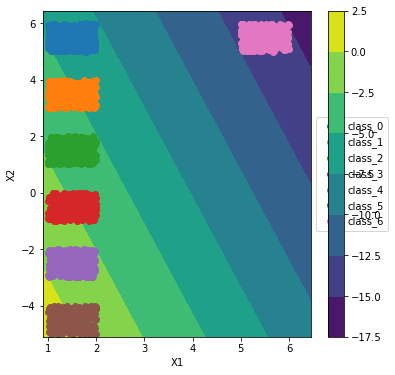

In [35]:
fig = plt.figure(figsize=(6,6))
cs = plt.contourf(X[:,0].reshape(xx.shape),X[:,1].reshape(yy.shape),Y.reshape(xx.shape))
plt.xlabel("X1")
plt.ylabel("X2")
fig.colorbar(cs)
for i in range(7):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("focus_contour.png")#,bbox_inches='tight')


In [36]:
Y1 = Y1.detach().numpy()
Y1 = torch.softmax(torch.Tensor(Y1),dim=1)
_,Z4= torch.max(Y1,1)
Z1 = Y1[:,0]
Z2 = Y1[:,1]
#Z3 = Y1[:,2]

In [37]:
np.unique(Z4)

array([0, 1, 2, 3, 4, 5])

In [38]:
#fig = plt.figure(figsize=(6,6))
# plt.scatter(X[:,0],X[:,1],c=Z1)
# plt.scatter(X[:,0],X[:,1],c=Z2)
# plt.scatter(X[:,0],X[:,1],c=Z3)
#cs = plt.contourf(X[:,0].reshape(xx.shape),X[:,1].reshape(yy.shape),Z1.reshape(xx.shape))
# #plt.colorbar(cs)
# cs = plt.contourf(X[:,0].reshape(xx.shape),X[:,1].reshape(yy.shape),Z2.reshape(xx.shape))
# #plt.colorbar(cs)
# cs = plt.contourf(X[:,0].reshape(xx.shape),X[:,1].reshape(yy.shape),Z3.reshape(xx.shape))
#plt.colorbar(cs)
# plt.xlabel("X1")
# plt.ylabel("X2")
#ax.view_init(60,100)
#plt.savefig("non_interpretable_class_2d.pdf",bbox_inches='tight')


In [39]:
avrg = []
with torch.no_grad():
  for i, data in  enumerate(train_loader):
          inputs , labels , fore_idx = data
          avg_inp,alphas = where(inputs)
          avrg.append(avg_inp)
avrg= np.concatenate(avrg,axis=0)

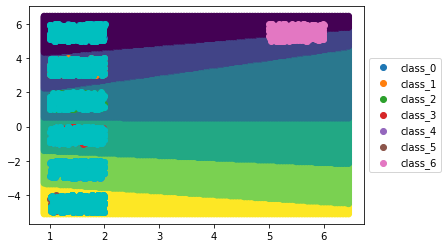

In [40]:
plt.scatter(X[:,0],X[:,1],c=Z4)
for i in range(7):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.scatter(avrg[:,0],avrg[:,1],c="c")
plt.savefig("decision_boundary.png",bbox_inches="tight")

In [41]:
true = []
pred = []
acc= 0
for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        avg_inp,alphas = where(inputs)
        outputs = what(avg_inp)
        _, predicted = torch.max(outputs.data, 1)
        true.append(labels)
        pred.append(predicted)
        acc+=sum(predicted == labels)

In [42]:
true = np.concatenate(true,axis=0)
pred = np.concatenate(pred,axis=0)

In [43]:
from sklearn.metrics import confusion_matrix
confusion_matrix(true,pred)

array([[505,   0,   0,   0,   0,   0],
       [  0, 490,   0,   0,   0,   0],
       [  0,   0, 484,   0,   0,   0],
       [  0,   0,   0, 522,   0,   0],
       [  0,   0,   0,   0, 486,   0],
       [  0,   0,   0,   0,   0, 513]])

In [44]:
sum(true==pred)

3000